In [9]:
%pip install opencv-python numpy matplotlib tensorflow keras

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model

In [2]:
# Directories for images and manual masks
image_dir = 'images1024x1024'
manual_mask_dir = 'manual-wrinkle-masks\manual_wrinkle_masks'

# Get lists of image and mask files
image_files = sorted(os.listdir(image_dir))
manual_mask_files = sorted(os.listdir(manual_mask_dir))

# Match images with available masks
matched_images = []
matched_masks = []

for mask_file in manual_mask_files:
    # mask file names correspond to image file names
    image_file = mask_file
    if image_file in image_files:
        matched_images.append(os.path.join(image_dir, image_file))
        matched_masks.append(os.path.join(manual_mask_dir, mask_file))

print(f"Number of matched images: {len(matched_images)}")


Number of matched images: 793


In [3]:
# Parameters
TARGET_SIZE = (256, 256)  

# Prepare data
images = []
masks = []

for image_path, mask_path in zip(matched_images, matched_masks):
    # Load image and mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  

    # Resize
    image = cv2.resize(image, TARGET_SIZE)
    mask = cv2.resize(mask, TARGET_SIZE)

    # Normalize image to range [0, 1]
    image = image / 255.0

    # Normalize mask to binary [0, 1]
    mask = (mask > 127).astype(np.float32)

    # Append to lists
    images.append(image)
    masks.append(mask)

# Convert to NumPy arrays
X = np.array(images, dtype=np.float32)
Y = np.array(masks, dtype=np.float32)

# Add a channel dimension to masks (required for U-Net output)
Y = np.expand_dims(Y, axis=-1)

print(f"Shape of X (images): {X.shape}")
print(f"Shape of Y (masks): {Y.shape}")

Shape of X (images): (793, 256, 256, 3)
Shape of Y (masks): (793, 256, 256, 1)


In [4]:
from sklearn.model_selection import train_test_split

# Split into training and testing sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, {Y_train.shape}")
print(f"Validation set: {X_val.shape}, {Y_val.shape}")
print(f"Test set: {X_test.shape}, {Y_test.shape}")


Training set: (634, 256, 256, 3), (634, 256, 256, 1)
Validation set: (79, 256, 256, 3), (79, 256, 256, 1)
Test set: (80, 256, 256, 3), (80, 256, 256, 1)


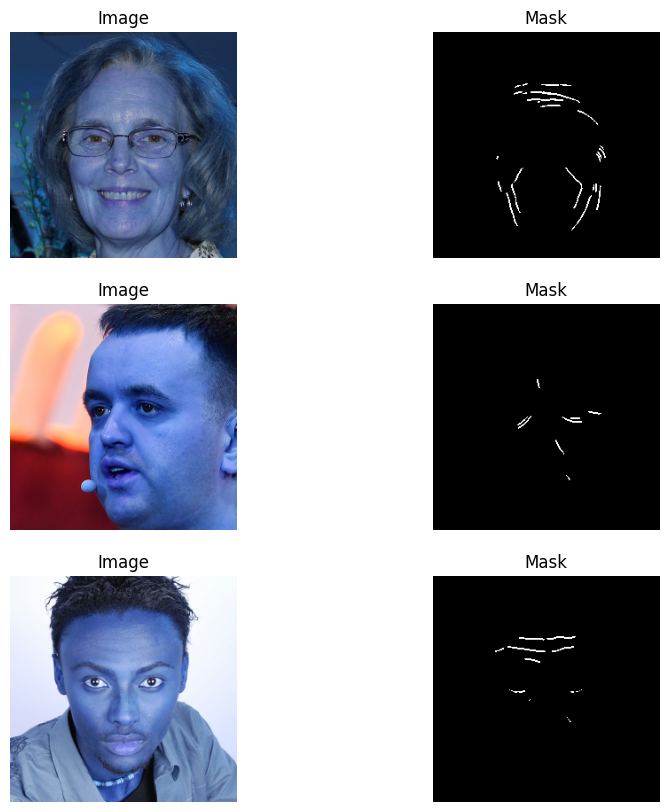

In [5]:
# Visualize some images and their corresponding masks
def visualize_data(images, masks, num_samples=3):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title('Image')
        
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')  # Remove channel dimension for visualization
        plt.axis('off')
        plt.title('Mask')
    plt.show()

visualize_data(X_train, Y_train)


In [6]:
def unet_model(input_shape=(256, 256, 3)):
    # Input layer
    inputs = layers.Input(input_shape)
    
    # Contracting path (Encoder)
    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = conv_block(p4, 1024)

    # Expanding path (Decoder)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = conv_block(u6, 512)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = conv_block(u7, 256)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = conv_block(u8, 128)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = conv_block(u9, 64)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Create model
    model = Model(inputs, outputs)
    return model


In [7]:
def conv_block(input_tensor, num_filters):
    """Convolutional block with two Conv2D layers followed by ReLU activation and BatchNorm."""
    x = layers.Conv2D(num_filters, (3, 3), padding='same', activation='relu')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(num_filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x

In [8]:
model = unet_model(input_shape=(256, 256, 3))
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])


In [10]:
history = model.fit(X_train, Y_train, 
                    validation_data=(X_val, Y_val), 
                    epochs=10, 
                    batch_size=16)


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1324s 33s/step - accuracy: 0.9938 - loss: 0.2430 - val_accuracy: 0.9946 - val_loss: 0.1667
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1269s 32s/step - accuracy: 0.9933 - loss: 0.1371 - val_accuracy: 0.9946 - val_loss: 0.1007
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1117s 28s/step - accuracy: 0.9932 - loss: 0.0863 - val_accuracy: 0.9946 - val_loss: 0.0734
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1166s 29s/step - accuracy: 0.9935 - loss: 0.0614 - val_accuracy: 0.9946 - val_loss: 0.0485
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1235s 31s/step - accuracy: 0.9934 - loss: 0.0484 - val_accuracy: 0.9946 - val_loss: 0.0455
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1375s 33s/step - accuracy: 0.9937 - loss: 0.0395 - val_accuracy: 0.9946 - val_loss: 0.0374
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1161s 29s/step - accuracy: 0.9941 - loss: 0.0335 - val_accuracy: 0.9946 - val_loss: 0.0351
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 11144s 285s/step - accuracy: 0.9939 - loss: 0.0305 - val_ac

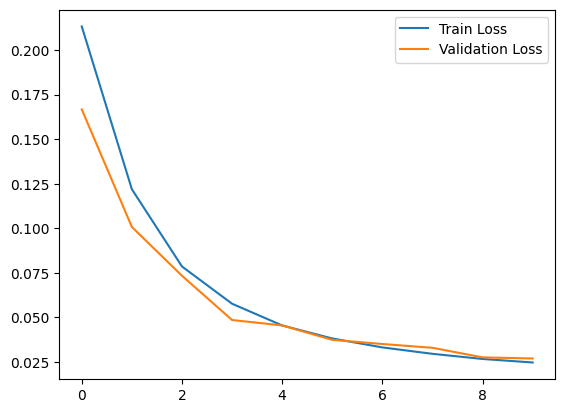

In [11]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [12]:
model.save('wrinkle_model.h5')

In [13]:
results = model.evaluate(X_test, Y_test)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 11s/step - accuracy: 0.9935 - loss: 0.0319
Test Loss: 0.03272159770131111
Test Accuracy: 0.9932834506034851


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


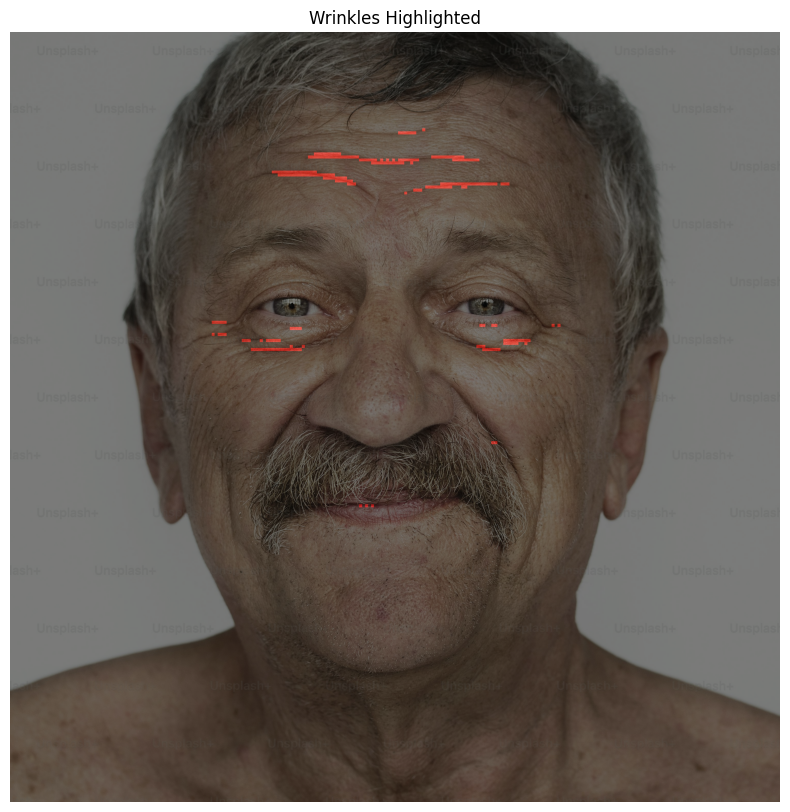

In [26]:
# Load and preprocess the original image
image = cv2.imread('face.jpeg')
original_size = image.shape[:2]  # Save original dimensions (height, width)

# Resize the image to the target size for prediction
image_resized = cv2.resize(image, TARGET_SIZE)
image_resized = image_resized / 255.0

# Expand dimensions for prediction
new_face = tf.expand_dims(image_resized, axis=0)

# Predict the wrinkle mask
predicted_mask = model.predict(new_face)
predicted_mask = (predicted_mask > 0.5).astype("uint8")  # Threshold to binary
predicted_mask = predicted_mask.squeeze()  # Remove batch and channel dimensions

# Resize the predicted mask back to the original image size
predicted_mask_resized = cv2.resize(predicted_mask, original_size[::-1], interpolation=cv2.INTER_NEAREST)

# Convert the mask to a 3-channel image for overlay
mask_overlay = np.zeros_like(image)
mask_overlay[:, :, 2] = predicted_mask_resized * 255  # Red channel for wrinkles

# Overlay the mask on the original image with transparency
alpha = 0.5  # Transparency factor
highlighted_image = cv2.addWeighted(image, 1 - alpha, mask_overlay, alpha, 0)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for plotting
plt.axis('off')
plt.title("Wrinkles Highlighted")
plt.show()